In [1]:
%matplotlib inline


# Color Quantization using K-Means

Performs a pixel-wise Vector Quantization (VQ) of an image of the summer palace
(China), reducing the number of colors required to show the image from 96,615
unique colors to 64, while preserving the overall appearance quality.

In this example, pixels are represented in a 3D-space and K-means is used to
find 64 color clusters. In the image processing literature, the codebook
obtained from K-means (the cluster centers) is called the color palette. Using
a single byte, up to 256 colors can be addressed, whereas an RGB encoding
requires 3 bytes per pixel. The GIF file format, for example, uses such a
palette.

For comparison, a quantized image using a random codebook (colors picked up
randomly) is also shown.


In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
import sewar

In [3]:
n_colors = 64

# Load the sample photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255
print(china.shape)
# Load the image and transform it to a 2D numpy array
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))
print(image_array.shape)


(427, 640, 3)
(273280, 3)


In [4]:
print("Fitting model on a small sub-sample of the data")

image_array_sample = shuffle(image_array, random_state=0)[:10000]
print(image_array_sample.shape)

#Perform K-means clustering on the sampled data
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)


# Get labels for all points

print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)


Fitting model on a small sub-sample of the data
(10000, 3)
Predicting color indices on the full image (k-means)


In [5]:
random_codebook = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
labels_random = pairwise_distances_argmin(random_codebook,
                                          image_array,
                                          axis=0)

Predicting color indices on the full image (random)


In [6]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [7]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

(427, 640, 3)


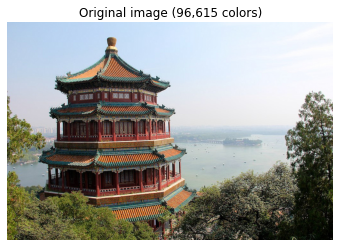

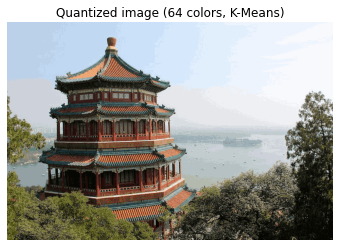

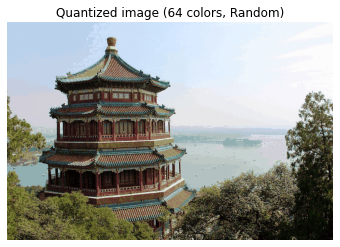

Error between K-means image and original image:
SSIM 0.9933932026908896
PSNR 80.38076299555705
Errors between K-means image and random image:
SSIM 0.9877440655007209
PSNR 75.31627871083751


In [20]:
# Display all results, alongside original image

k_means_quantized_image = recreate_image(kmeans.cluster_centers_, labels, w, h)
print(k_means_quantized_image.shape)
random_quantized_image = recreate_image(random_codebook, labels_random, w, h)

plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(k_means_quantized_image)

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(random_quantized_image)
plt.show()

print('Error between K-means image and original image:')
print('SSIM',sewar.full_ref.uqi(k_means_quantized_image, china))
print('PSNR',PSNR(k_means_quantized_image, china))

print('Errors between K-means image and random image:')
print('SSIM',sewar.full_ref.uqi(k_means_quantized_image, random_quantized_image))
print('PSNR',PSNR(k_means_quantized_image, random_quantized_image))

In [14]:
!pip install opencv-python

In [26]:
matplotlib.image.imsave('name1.png', china)